In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
# Root directory of the project
ROOT_DIR = os.path.abspath("/lfs/jonas/maskrcnn/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [2]:
class SatsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "sats"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (128,128)
    
config = SatsConfig()

In [3]:
def load_image(image_path):
    """Load the specified image and return a [H,W,3] Numpy array.
    """
    from skimage.io import imread

    image = np.array(imread(image_path), dtype=float)
        
    bands = [4,2,1]
            
    image = image[:,:,bands]
        
    #image = (image * 255) / image.max()
        
    mean_std_data = np.loadtxt('image_mean_std.txt', delimiter=',')
    mean_std_data = mean_std_data[bands,:]
    image = preprocessing_image_ms(image, mean_std_data[:,0], mean_std_data[:,1])
        
    return image   
    
def load_orig_image(image_path):
    """Load the specified image (without stand.) and return a [H,W,3] Numpy array.
    """
    from skimage.io import imread
    # Load image
    image = np.array(imread(image_path), dtype=float)
        
    bands = [4,2,1]
        
    image = image[:,:,bands]
        
    image = (image * 255) / image.max()
        
    return image   
def preprocessing_image_ms(x, mean, std):
    # loop over image bands
    for idx, mean_value in enumerate(mean):
        x[..., idx] -= mean_value
        x[..., idx] /= std[idx]
    return x


In [47]:
valid_image_path = '/data/spacenet/bldg/data/validation/MUL/'
valid_glob = glob(valid_image_path + '*.tif')

In [50]:
image_path = random.sample(valid_glob, 1)[0]

In [51]:
stan_image = load_image(image_path)
orig_image = load_orig_image(image_path)

In [54]:
def scale_coord(geom, image):

        scale_x = abs(geom[0] - image.bounds[0]) * abs(image.width / (image.bounds[0] - image.bounds[2]))
        scale_y = abs(geom[1] - image.bounds[3]) * abs(image.height / (image.bounds[1] - image.bounds[3]))


        return scale_x, scale_y
def preprocessing_image_ms(x, mean, std):
        # loop over image bands
        for idx, mean_value in enumerate(mean):
            x[..., idx] -= mean_value
            x[..., idx] /= std[idx]
        return x
    
def load_mask(input_path, geojson_path):
        import cv2
        import os
        import json
        import rasterio as rio
        import numpy as np
        import scipy.ndimage as ndi
        
        image_filename = os.path.split(input_path)[-1]
        json_filename = 'buildings' + image_filename[14:-4] + '.geojson'
        geojson_file = os.path.join(geojson_path, json_filename)
        print(json_filename)
        #Load JSON
        with open(geojson_file, 'r') as f:
            geo_json = json.load(f)
    
        #Open image to get scale
        image = rio.open(input_path)
        image_shape = image.shape
        #Load and scale all the polygons (buildings)
        polys = []

        for feature in geo_json['features']:
            scaled_coordSet = []
            if feature['geometry']['type'] == 'Polygon':
                for coordinatesSet in feature['geometry']['coordinates']:
                    for coordinates in coordinatesSet:
                        scale_x, scale_y = scale_coord(coordinates, image)
                        scaled_coordSet += [[scale_x, scale_y]]

        
            if feature['geometry']['type'] == 'MultiPolygon':
                for polygon in feature['geometry']['coordinates']:
                    for coordinatesSet in polygon:
                        scaled_coord = []
                        for coordinates in coordinatesSet:
                            scale_x, scale_y = scale_coord(coordinates, image)
                            scaled_coord += [[scale_x, scale_y]]
                    scaled_coord = np.array(scaled_coord)
                scaled_coordSet += [scaled_coord]

            geom_fixed = np.array(scaled_coordSet, dtype=np.int32)
    
            if geom_fixed.shape[0] != 0:
                polys += [geom_fixed]

        polys = np.array(polys)

        mask = np.zeros(image_shape)
        cv2.fillPoly(mask, polys, 1)
    
        mask = mask.reshape(mask.shape[0], mask.shape[1])
        
        segs, count = ndi.label(mask)
        if count == 0:
            maskArr = np.empty([0, 0, 0])
            class_ids = np.empty([0], np.int32)
        else:
            maskArr = np.empty((segs.shape[0], segs.shape[1]))
            class_id_list = []
            for i in range(1, count+1):
                intArr = (segs == i)
                intArr.astype(int)
                maskArr = np.dstack((maskArr, intArr))
                class_id_list += [1]
            maskArr = np.delete(maskArr, 0, axis=2)
            
            class_ids = np.array(class_id_list)
        return maskArr, class_ids

In [56]:
mask, _ = load_mask(image_path, '/data/spacenet/bldg/data/validation/geojson/')
mask.shape

buildings_AOI_2_Vegas_img3701.geojson


<ipython-input-54-bd04f0fb5c65>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)


(650, 650, 27)

In [59]:
bbox = utils.extract_bboxes(mask)

[  4  83  70 179]


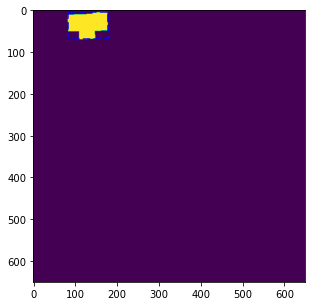

In [82]:
from matplotlib import patches
print(bbox[2])
y1, x1, y2, x2 = bbox[2]
_, ax = plt.subplots(1, figsize=(5,5))
p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                      alpha=0.7, linestyle="dashed",
                      edgecolor='blue', facecolor='none')
ax.add_patch(p)
ax.imshow(mask[:,:,2])